# __Deep Learning or Computer Vision - Final Project - Group 8__

__Notebook Contents:__
1. [Project Overview](#1.-Project-Overview)
    - [Introduction](#Introduction)
    - [Repository Structure](#Repository-Structure)
    - [Requirements](#Requirements)
2. [Individual Project Parts](#2.-Individual-Project-Parts)
    - [Part 1: Face Detection](#Part-1:-Face-Detection)
    - [Part 2: Facial Recognition](#Part-2:-Facial-Recognition)
    - [Part 3: Emotion Recognition](#Part-3:-Emotion-Recognition)
3. [Full Project Integration](#3.-Full-Project-Integration)
    - [Initialization](#Initialization)
    - [Image Example](#Image-Example)
    - [Webcam Example (try it yourself)](#Webcam-Example-(try-it-yourself))

<br>

## __1. Project Overview__

### __Introduction__

- Our final project combines several deep learning models (face detection, facial recognition, emotion recognition) to create a marketing application.
- This notebook serves as the main code file in which we link all code modules and datasets in our repository.
- The main purpose of this notebook is to provide an overview of our code. For a detailed explanation of our models and business application, please refer to our presentation file.

### __Repository Structure__

- The project is structured into three main parts: face detection, face recognition, and emotion recognition.
- Each of these three parts is covered individually in the following sections of this notebook.
- The last section combines all three individual parts into one fully integrated program.
- Each section can also be run on its own without running the other parts before.
- In order to keep this notebook clear, concise and executable in reasonable time, we simply import the weights obtained from our model training. To see the exact training processes, please have a look at the training notebooks in the respective model folders in the repository.
- The repository structure is shown below. Since we use relative paths in our project, please leave the repository folder structure as it is.

`
cv_project_group8/
│   README.txt                            ---introduction to the project
│   requirements.txt                      ---required packages
│   cv_group8_notebook.ipynb              ---main code file linking all code and data
│   cv_group8_presentation.pdf            ---presentation about our models and business application
│
└───face_detection/
│       configs/                          ---contains configuration files of RetinaFaceModel
│       checkpoints/                      ---training checkpoints
│       data/                             ---used for training, benchmarking, and illustration
│       .py modules                       ---various functionalities related to face detection
│       FaceDetector_training.ipynb       ---model training
│
└───facial_recognition/
│       data/                             ---used for training, benchmarking, and illustration
│       models/                           ---face recognition models (OpenFace pretrained weights)
│       trained_model/                    ---our trained network
│       openface/                         ---the openface GitHub repository
│       .py modules                       ---various functionalities related to data handling
│       facial_recognition_training.ipynb ---model training and benchmarking
│
└───emotion_recognition/
│       models/                           ---emotion recognition models and weights
│       example_images/                   ---example images for illustration in our notebook
│       Emotion_Training.ipynb            ---emotion recognition training notebook (for reconstruction unzip Emotion_Training_full.zip)
│       Emotion_Benchmarking.ipynb        ---emotion recognition benchmarking (for reconstruction unzip Emotion_Training_full.zip)
│       Emotion_Training_full.zip         ---all files required to reconstruct emotion recognition training and benchmarking
│
└───full_project_integration/
        data/                             ---used for examples and illustration
        full_model.py                     ---combination of the three part into one integrated program
        database_mgmt.py                  ---functionalities related to database handling
        db_example.json                   ---exemplary database
`

### __Requirements__

- For the repository to run correctly and completely, all libraries from the requirements.txt file must be installed.
- If you are using Windows, you may experience difficulties installing dlib and the corresponding face_recognition library (not to be confused with our facial_recognition folder in the repository).<br>To install dlib successfully on Windows, it must be build using Cmake and Visual Studio. Once dlib is installed face_recognition can simply be installed using pip.

In [ ]:
# Install required packages for this project
!pip install -r requirements.txt

 <br>
 
# __2. Individual Project Parts__

# Part 1: Face Detection

The first part of our project needs to:
1. take images or videos as an input,
2. collect individual frames in the case of a video,
3. detect faces on the images/frames,
4. align and extract the detected faces.

For this part of the project we've mainly relied on most of the code in [this repository](https://github.com/peteryuX/retinaface-tf2) to replicate a CNN able to do SOTA face detection. Indeed, the first step of our chain needs to pick up faces from a store footage and identify faces correctly to then classify their emotion and do face recognition. The model used is [RetinaFace (Deng et al 2019)](https://arxiv.org/pdf/1905.00641.pdf), a Single Stage detection network which offers more solid results in face detection by leveraging facial landmarks (eyes, nose, mouth corners). 

It comes with both a ResNet50 and MobileNetV2 backbones and we've retrained both of them (for the training refer to the training notebook inside the `face_detection` folder).

### Setup Face Detection Model

In [1]:
# Import required packages for this part (face detection)
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import tensorflow as tf
from absl import logging

# Import project part scripts from repository
from face_detection.models import RetinaFaceModel
from face_detection.utils import (load_yaml, set_memory_growth, pad_input_image, 
                                  recover_pad_output, draw_bbox_landm, align_face)

In [2]:
# Set working device
set_memory_growth() # avoid memory problems
os.environ['CUDA_VISIBLE_DEVICES'] = '0' # use just gpu, uses cpu if no CUDA compatible device is found

# Get rid of the ugly tensorflow logging
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
logger = tf.get_logger()
logger.disabled = True
logger.setLevel(logging.FATAL)

# Define network (if run for the first time will download MobileNetv2/ResNet50 weights for the backbone)
cfg = load_yaml('face_detection/configs/retinaface_mbv2.yaml') # res50, mbv2
detector = RetinaFaceModel(cfg, training=False, 
                        iou_th=0.25,        # IOU threshold for nms
                        score_th=0.95)      # Minimum score for face confidence

# Load last checkpoint with weights
checkpoint = tf.train.Checkpoint(model = detector)
checkpoint.restore(tf.train.latest_checkpoint('face_detection/checkpoints/' + cfg['sub_name']))

### Single Frame Example

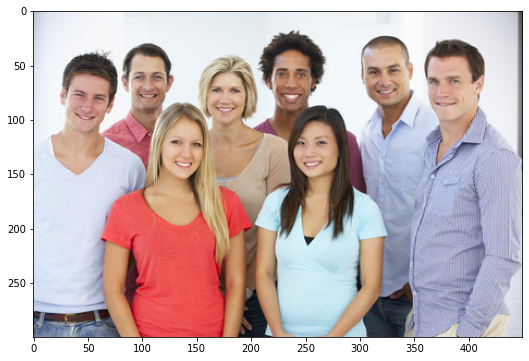

In [3]:
# Load image
img_path = 'face_detection/data/group_stock_image.jpg'
image = mpimg.imread(img_path)

# Show image
plt.figure(figsize = (12,6))
plt.imshow(image)

Detected 8 faces


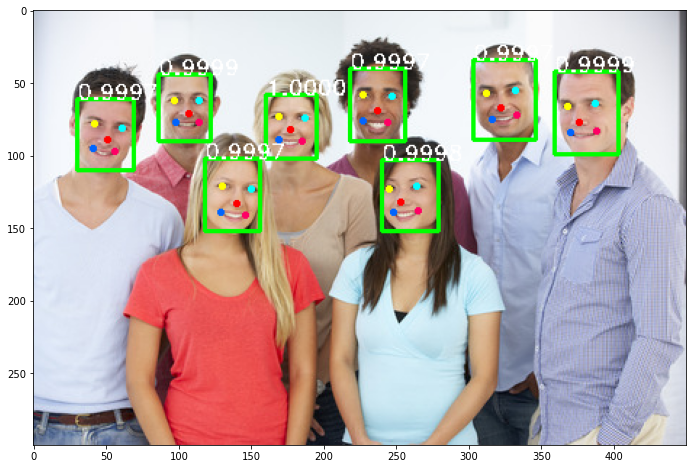

In [4]:
### DETECT FACES IN THE FRAME ###

# Image manipulation to feed to the detector
if image.shape[0] > 1280: # reduce size in case of very large images
    rescale_factor = 1280 / image.shape[0]
    image = cv2.resize(image, (int(image.shape[1] * rescale_factor), 1280))
frame = np.float32(image.copy())   # convert to float32
frame, pad_params = pad_input_image(frame, max_steps=max(cfg['steps'])) # pad input image to avoid unmatched shape problems

# Run inference (detect faces)
det_faces = detector(frame[np.newaxis, ...]).numpy()
det_faces = recover_pad_output(det_faces, pad_params) # recover padding effect
print(f"Detected {len(det_faces)} faces")

# Visualization example of bboxes and landmarks
copy = image.copy() 
for face in det_faces:
    draw_bbox_landm(copy, face)
plt.figure(figsize = (16,8))
plt.imshow(copy)

### Alignment and Extraction

Of the 8 detected, 8 are at least 32x32 pixels


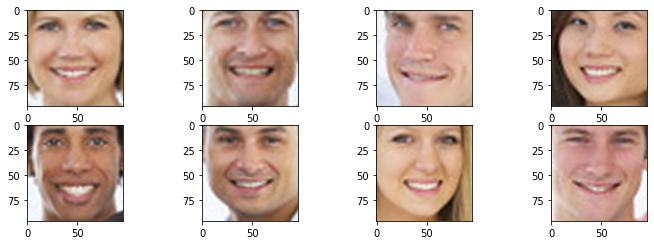

In [5]:
# List comprehension to align and filter out when the align function returns None 
aligned_faces = [al_face / 255 for al_face in        # normalize to range 0-1
                 (align_face(image, face,            # image and annotations of detected face
                            min_face_size = 32,      # chose min size to include (32x32 pixels)
                            o_size = (96,96),        # resize shape to output
                            eyes_wh = (0.25,0.15))   # zoom over face
                  for face in det_faces)
                 if al_face is not None]
print(f'Of the {len(det_faces)} detected, {len(aligned_faces)} are at least 32x32 pixels')

# Visualization of output
plt.figure(figsize = (12,6))
pos = 1
for face in aligned_faces:
    plt.subplot(3, 4, pos)
    pos += 1
    plt.imshow(face)

### Video reading (+webcam) with face detection
Using cv2.VideoCapture utility we can easily read videos (e.g. .mp4, .avi, etc) by feeding the function the path to the location of the video. It is also possible to input a video stream (e.g. setting '0' as argument it uses the laptop camera as video input).

Since video streams can have different fame rates, the choice to use only 1 frame for 1 second of video seems reasonable to not bloat the hardware and run inference on different images.  

To show an example, the timer is set to run inference every 0.2 to give a sense of movement (it is otherwise set to 1.0).

**!!!cv.imshow() cannot be run inline with the notebook, a new window will open where it'll show the video (close early by pressing q)!!!**

In [7]:
# Select input (either example video or webcam)
path_to_vid = 'face_detection/data/example_video.mp4'  # example video
#path_to_vid = 0                                       # Use your webcam

# Start reading video
vid = cv2.VideoCapture(path_to_vid)
grabbed, frame = vid.read() # grabbed is bool
last_rec_time = time.time()

# Keep looping till video is cut out or ends
while grabbed:
    curr_time = time.time()
    if curr_time - last_rec_time >= 0.2: # would be 1 sec
        
        # pad image, inference, recover output
        img = np.float32(frame.copy())
        img = img[..., ::-1]
        img, pad_params = pad_input_image(img, max_steps=max(cfg['steps']))
        outputs = detector(img[np.newaxis, ...]).numpy()
        outputs = recover_pad_output(outputs, pad_params)
        
        # draw bbox, landmarks for visualization
        for out in outputs:
            draw_bbox_landm(frame, out)
            
        # new timer
        last_rec_time = curr_time
        cv2.imshow('frame', frame)
        
    # get new frame and restart loop if grabbed is true (otherwise the video ended)
    grabbed, frame = vid.read() 
    
    # can close the video early by pressing 'q' on the keyboard
    if cv2.waitKey(1) == ord('q'):
        break

# End video (press q)
vid.release()
cv2.destroyAllWindows()

### Benchmarking
Testing average Intersection over Union, Average Precision and average inferencing times.
Each of these models is run on a set of images and the detections are compared with the bounding box truth (bounding boxes with width or height lower than 32 pixels are discarded because they are considered not informative enough for our face and emotion recognition).

Running this on your local machine might take a long time since models 3-6 are build for GPU so we recommend running it on Google Colab (use *iou_th=0.5* and *score_th=0.85* in the model setup to reconstruct our results). **The Benchmarking section does not influence the rest of the notebook so it can be skipped without affecting the rest of the notebook.** We already ran the cells on Colab so the outputs are shown below.

* OpenCV Haar Cascades Classifier
>OpenCV implemented Viola and Jones Algorithm for face detection [Paper (2001)](https://www.cs.cmu.edu/~efros/courses/LBMV07/Papers/viola-cvpr-01.pdf)
* DLib Histogram of Oriented Gradients
> Dlib implementation of Dalal and triggs [Paper (2005)](https://hal.inria.fr/file/index/docid/548512/filename/hog_cvpr2005.pdf)
* DLib Convolutional Neural Network 
> Dlib implemented Max-Margin Object Detection [King 2015](https://arxiv.org/pdf/1502.00046.pdf)
* Multi-Task Cascade CNN
>[Zhang et al.(2016)](https://arxiv.org/ftp/arxiv/papers/1604/1604.02878.pdf)
* RetinaFace Both with ResNet50 and MobileNetv2
>[Deng et al (2019)](https://arxiv.org/pdf/1905.00641.pdf)
* Graphical Comparison

In [ ]:
### COMPARE THE PERFORMANCE OF OUR FACE DETECTION MODEL WITH OTHER MODELS ###
from face_detection.facedetectors import (OpenCVHaarFaceDetector,
                                         DlibHOGFaceDetector,
                                         DlibCNNFaceDetector,
                                         MTCNNFaceDetector,
                                         RetinaFaceDetector,
                                         get_iou, extract_and_filter_data, evaluate)

# Create dictionary of image path and faces for 'val' set of widerface
data_dict = extract_and_filter_data()

In [ ]:
face_detector = OpenCVHaarFaceDetector(scaleFactor=1.3, minNeighbors=5)
res1 = evaluate(face_detector, data_dict)

print('Average IOU = %s' % (str(res1['average_iou'])))
print('AP = %s' % (str(res1['average_precision'])))
print('Average inference time = %s' % (str(res1['average_inferencing_time'])))

100%|██████████| 2208/2208 [17:33<00:00,  2.10it/s]

Average IOU = 0.21480984663113314
AP = 0.3024396540892532
Average inference time = 0.22263198928988498


In [ ]:
face_detector = DlibHOGFaceDetector(nrof_upsample=0, det_threshold=-0.2)
res2 = evaluate(face_detector, data_dict)

print('Average IOU = %s' % (str(res2['average_iou'])))
print('AP = %s' % (str(res2['average_precision'])))
print('Average inference time = %s' % (str(res2['average_inferencing_time'])))

100%|██████████| 2208/2208 [05:58<00:00,  6.16it/s]

Average IOU = 0.24326135678096153
AP = 0.3517367721039289
Average inference time = 0.14526163581488788


In [ ]:
face_detector = DlibCNNFaceDetector(nrof_upsample=0, model_path='face_detection/data/mmod_human_face_detector.dat')
res3 = evaluate(face_detector, data_dict)

print('Average IOU = %s' % (str(res3['average_iou'])))
print('AP = %s' % (str(res3['average_precision'])))
print('Average inference time = %s' % (str(res3['average_inferencing_time'])))

100%|██████████| 2208/2208 [01:51<00:00, 19.86it/s]

Average IOU = 0.2816258700276374
AP = 0.4072016809776775
Average inference time = 0.035329509256542595


In [ ]:
face_detector = MTCNNFaceDetector(min_face_size = 32, steps_threshold = [0.5, 0.7, 0.7])
res4 = evaluate(face_detector, data_dict)

print('Average IOU = %s' % (str(res4['average_iou'])))
print('AP = %s' % (str(res4['average_precision'])))
print('Average inference time = %s' % (str(res4['average_inferencing_time'])))

100%|██████████| 2208/2208 [17:58<00:00,  2.05it/s]

Average IOU = 0.407842460465132
AP = 0.5105211982745536
Average inference time = 0.4714736254966777


In [ ]:
face_detector = RetinaFaceDetector(cfg_path = 'face_detection/configs/retinaface_res50.yaml', iou_th = 0.5, score_th = 0.85)
res5 = evaluate(face_detector, data_dict)

print('Average IOU = %s' % (str(res5['average_iou'])))
print('AP = %s' % (str(res5['average_precision'])))
print('Average inference time = %s' % (str(res5['average_inferencing_time'])))

94773248/94765736 [==============================] - 2s 0us/step


  0%|          | 0/2208 [00:00<?, ?it/s]

[*] load ckpt from face_detection/checkpoints/retinaface_res50/ckpt-29.


100%|██████████| 2208/2208 [09:20<00:00,  3.94it/s]

Average IOU = 0.648106987678345
AP = 0.7913592235193497
Average inference time = 0.2366503183392511


In [ ]:
face_detector = RetinaFaceDetector(cfg_path = 'face_detection/configs/retinaface_mbv2.yaml', iou_th = 0.5, score_th = 0.85)
res6 = evaluate(face_detector, data_dict)

print('Average IOU = %s' % (str(res6['average_iou'])))
print('AP = %s' % (str(res6['average_precision'])))
print('Average inference time = %s' % (str(res6['average_inferencing_time'])))

  0%|          | 0/2208 [00:00<?, ?it/s]

[*] load ckpt from face_detection/checkpoints/retinaface_mbv2/ckpt-63.


100%|██████████| 2208/2208 [07:59<00:00,  4.60it/s]

Average IOU = 0.6546343778529948
AP = 0.7972794426102939
Average inference time = 0.1999499806459399


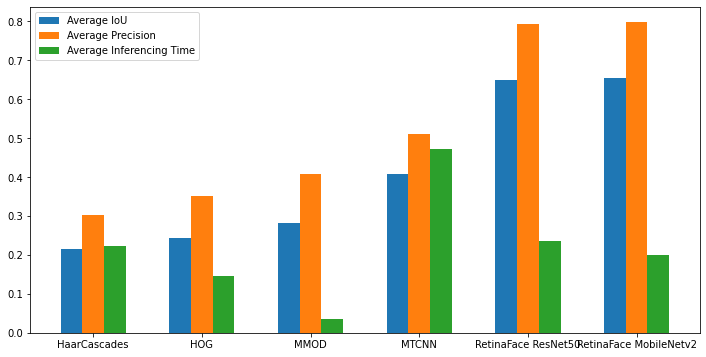

In [10]:
### GRAPHICAL COMPARISON ###
method = ['HaarCascades', 'HOG', 'MMOD', 'MTCNN', 'RetinaFace ResNet50', 'RetinaFace MobileNetv2']
aIOU = []
AP = []
InferT = []
for d in [res1, res2, res3, res4, res5, res6]:
    aIOU.append(d['average_iou'])
    AP.append(d['average_precision'])
    InferT.append(d['average_inferencing_time'])

x = np.arange(len(method))
width = .2

fig, ax = plt.subplots(figsize = (12,6))
ax.bar(x - width, aIOU, width, label = 'Average IoU')
ax.bar(x, AP, width, label = 'Average Precision')
ax.bar(x + width, InferT, width, label = 'Average Inferencing Time')
ax.set_xticks(x)
ax.set_xticklabels(method)
ax.legend()
plt.show()

 <br>
 
# Part 2: Facial Recognition

This part of the project:
1. takes as an input the detected and aligned faces from part 1,
2. creates an 128-dimensional embedding for each detected face,
3. compares the created embedding to other embeddings in a database to find potential matches of the same person.

We mainly use the OpenFace model since it has shown very good performance despite being relatively lightweight [(Amos, 2016)](http://elijah.cs.cmu.edu/DOCS/CMU-CS-16-118.pdf).<br>
Using tranfer learning, we continue training OpenFace ourselves with a siamese model, triplet loss and online hard triplet batch generation (see training notebook).<br>
In the benchmarking section, we compare the performance with the face_recognition library included in dlib which uses a resnet architecture.

### Setup

In [8]:
# Import required packages for this part (facial recognition)
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import tensorflow as tf
from tensorflow import keras
import face_recognition as dlib_face_rec
from sklearn.metrics import f1_score, accuracy_score
from sklearn.preprocessing import LabelEncoder

# Import project part scripts from repository
from facial_recognition import data_creation
from facial_recognition import data_preprocessing
from facial_recognition.models.openface_model import model

In [9]:
# Load our own model trained with transfer learning
model = keras.models.load_model('facial_recognition/trained_model')

# You can find our training notebook which we ran on Google Colab in the folder 'facial_recognition'.
# We took a transfer learning approach by removing the last layer from the original model, freezing the pretrained weights and then adding our own dense layer
# at the top of the model to be trained. To do so, we used a siamese model with triplet loss and online hard triplet batch generation.
# For details, refer to our training notebook.

### Data Preparation

In [10]:
# Load example dataset
data_example = data_creation.load_data_lfwcrop('facial_recognition/data/example_dataset')
data_facerec = data_creation.merge_data([data_example])
print(f'Dataset facerec created: {sum([sum([len(li) for li in val]) for val in data_facerec.values()])} images of {len(data_facerec)} different individuals.')

Dataset facerec created: 222 images of 10 different individuals.


X type: <class 'numpy.ndarray'>, X shape: (222, 96, 96, 3)
labels type: <class 'list'>, labels length: 222


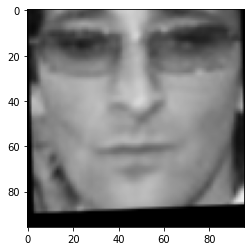

In [11]:
# Several preprocessing operations
# in the full model we will already get the preprocessed images from the face_detection part
X, labels = data_preprocessing.dict_to_model_input(data_facerec, 
                                                   grey2rgb=True, 
                                                   normalize=True, 
                                                   alignment=True, 
                                                   new_size=(96, 96))

# Encode labels
le = LabelEncoder()
le.fit(labels)
y = le.transform(labels)

# Visualize example of preprocessed image
print(f'X type: {type(X)}, X shape: {X.shape}')
print(f'labels type: {type(labels)}, labels length: {len(labels)}')
plt.imshow(X[20])

### Example

In [12]:
# Get an embedding for each face image in the dataset
X_emb = model.predict(X)
print(f'{len(X_emb)} images have been embedded.')
print(f'Each embedding is a vector with {X_emb[0].shape} dimensions')
print(f'X_emb.shape = {X_emb.shape}')

222 images have been embedded.
Each embedding is a vector with (128,) dimensions
X_emb.shape = (222, 128)


In [13]:
# Calculate the Euclidean distance of each embedding to a reference image
ref_idx = 20 # index of reference image
distances = []
for idx, val in enumerate(X_emb):
	distances.append(np.linalg.norm(val - X_emb[ref_idx]))

# Sort labels using Euclidean distance (L2 norm)
labels = np.array(labels)
distances = np.array(distances)
indices = distances.argsort()
sorted_labels = labels[indices]
sorted_distances = distances[indices]

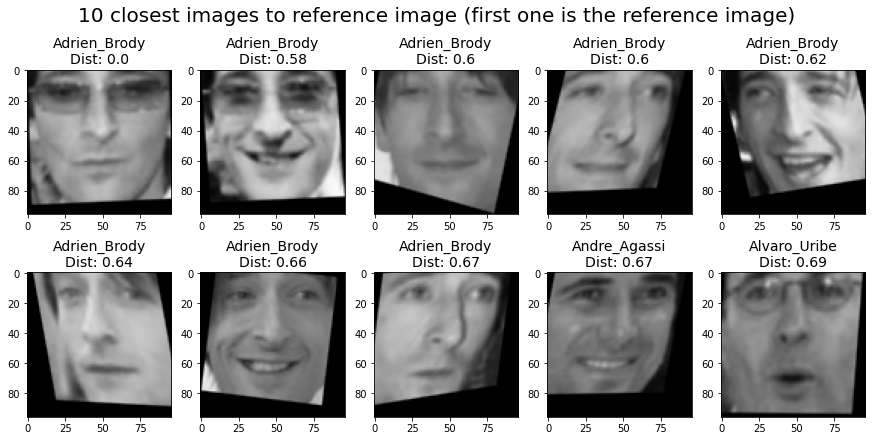

In [14]:
# Plot results
# The first image shown is the reference image.
# The next images are the closest related in the dataset according to our model.
fig, ax = plt.subplots(2, 5, figsize=(12, 6), constrained_layout=True)
axes = ax.flatten()
fig.suptitle(f'10 closest images to reference image (first one is the reference image)', fontsize=20)
for idx, val in enumerate(indices[:10]): # 10 closest images to reference image
	axes[idx].imshow(X[val])
	axes[idx].set_title(f'{labels[val]}\nDist: {round(float(sorted_distances[idx]), 2)}', fontsize=14)
plt.show()

# RESULT:
# The reference image is Adrien Brody.
# The first seven closest guesses of the model are all correctly Adrien Brody.
# Only the eight closest image is Andre Agassi instead.

# A Note on the database:
# In the full model we save embeddings in a database and compare new embeddings to previous entries 
# like we did here with the small dataset (see last section of this notebook for our database approach).

### Benchmarking
- The next cells show our benchmarking results to illustrate how our trained model compares to the pretrained model and to the dlib face recognition model.<br>
- The benchmarking was done in the training notebook after model training on the Google Colab GPU.
- **These benchmarking cells can not be run from this notebook. They were copied from the training notebook in the repository folder `facial_recognition`. <br>Please refer to that file to see our training and benchmarking process.**
- Benchmarking result: We are able to slightly improve the accuracy of the OpenFace model through our training. The Dlib model is even more accurate, but our model is about ten times faster in embedding.

In [178]:
### EMBEDDING TIMING ON GPU - OPENFACE PRETRAINED ### 

from facial_recognition.models.openface_model import model as pretrained_network
pretrained_network.load_weights('facial_recognition/models/openface_weights.h5')     # <--- Pretrained weights

time_a = time.time()
x_emb_openface_pretrained = pretrained_network.predict(x_benchmark_openface)
time_b = time.time()

openface_time = time_b - time_a
print(f'Openface pretrained time: {openface_time} to embed {x_emb_openface_pretrained.shape[0]} faces.', x_emb_openface_pretrained.shape)

Openface pretrained time: 0.6306562423706055 to embed 1304 faces. (1304, 128)


In [180]:
### EMBEDDING TIMING ON GPU - OPENFACE TRANSFER LEARNING ###

time_a = time.time()
x_emb_openface_trained = network.predict(x_benchmark_openface)
time_b = time.time()

openface_time = time_b - time_a
print(f'Openface time: {openface_time} to embed {x_emb_openface_trained.shape[0]} faces.', x_emb_openface_trained.shape)

Openface time: 0.6386475563049316 to embed 1304 faces. (1304, 128)


In [182]:
### EMBEDDING TIMING ON GPU - DLIB ###

# Run model
time_a = time.time()
x_emb_dlib = np.array([dlib_face_rec.face_encodings(x, [(0,95,95,0)])[0] for x in x_benchmark_dlib])
time_b = time.time()

dlib_time = time_b - time_a
print(f'Dlib time: {dlib_time} to embed {x_emb_dlib.shape[0]} faces.', x_emb_dlib.shape)

Dlib time: 6.827467918395996 to embed 1304 faces. (1304, 128)


Optimal treshold: 0.75
Optimal f1-score: 0.5506522342492368
Accuracy at maximal F1 score: 0.9847543893516143


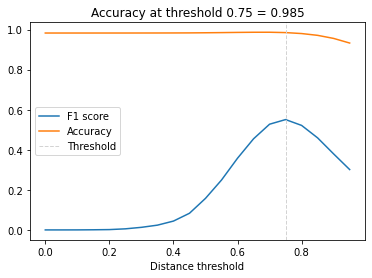

In [179]:
### BENCHMARKING - OPENFACE PRETRAINED ###

thresholds = np.arange(0.0, 1.0, 0.05)
distances, identical = calc_distances(x_emb_openface_pretrained, y_benchmark_openface)
opt_tau, opt_acc, opt_f1 = evaluate_performance(distances, identical, thresholds)

print('Optimal treshold:', opt_tau)
print('Optimal f1-score:', opt_f1)
print('Accuracy at maximal F1 score:', opt_acc)

Optimal treshold: 0.75
Optimal f1-score: 0.5801373974521443
Accuracy at maximal F1 score: 0.9851804942817189


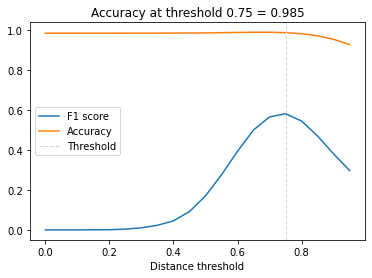

In [181]:
### BENCHMARKING - OPENFACE TRANSFER LEARNING ###

thresholds = np.arange(0.0, 1.0, 0.05)
distances, identical = calc_distances(x_emb_openface_trained, y_benchmark_openface)
opt_tau, opt_acc, opt_f1 = evaluate_performance(distances, identical, thresholds)

print('Optimal treshold:', opt_tau)
print('Optimal f1-score:', opt_f1)
print('Accuracy at maximal F1 score:', opt_acc)

Optimal treshold: 0.49999999999999994
Optimal f1-score: 0.7031983730819006
Accuracy at maximal F1 score: 0.9905515351548339


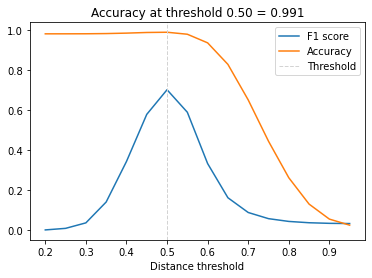

In [183]:
### BENCHMARKING - DLIB ###

thresholds = np.arange(0.2, 1.0, 0.05)
distances, identical = calc_distances(x_emb_dlib, y_benchmark_dlib)
opt_tau, opt_acc, opt_f1 = evaluate_performance(distances, identical, thresholds)

print('Optimal treshold:', opt_tau)
print('Optimal f1-score:', opt_f1)
print('Accuracy at maximal F1 score:', opt_acc)

 <br>
 
# Part 3: Emotion Recognition

- This part of the project takes as an input the detected and aligned faces from the first part of the project (face_detection).
- It classifies each detected face as having one of seven possible emotions: neutral, happy, surprise, sad, anger, disgust, fear.
- It also gives predicted probabilities for each of the seven classes.

### Setup

In [15]:
# Import relevant packages for this part of the project (emotion detection)
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
from keras.models import model_from_json

### Model
We simply import our training weights here. For the documentation of our training, please refer to the training notebook in the `emotion_detection` folder.

In [16]:
# Create a class for our model
class FacialExpressionModel(object):
    
    EXPRESSIONS_LIST = ['neutral','happy','surprise', 'sad','anger', 'disgust','fear']

    def __init__(self, model_json_file, model_weights_file):
        # load model from JSON file
        with open(model_json_file, "r") as json_file:
            loaded_model_json = json_file.read()
            self.loaded_model = model_from_json(loaded_model_json)

        # load weights into the new model
        self.loaded_model.load_weights(model_weights_file)
        
    def predict_emotion(self, img):
        self.preds = self.loaded_model.predict(img)
        return FacialExpressionModel.EXPRESSIONS_LIST[np.argmax(self.preds)], self.preds
    
# Create instance of model with our weights
pic_to_exp = FacialExpressionModel("emotion_recognition/models/resnet_50_model.json",
                                   "emotion_recognition/models/resnet_50_75e.h5")  

In [17]:
# Preprocess face_detection output for this part
def mk_gray_tensor(numpy_array):
    image = tf.convert_to_tensor(numpy_array, dtype=tf.float32)
    image = tf.tile(tf.image.rgb_to_grayscale(image), [1, 1, 3])
    image = tf.expand_dims(image, axis=0)
    return tf.cast(image, tf.float32) / 255.0

### Examples

(96, 96, 3)
(1, 96, 96, 3)


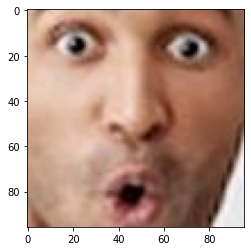

In [26]:
# Load and show second example
example2 = mpimg.imread("emotion_recognition/example_images/surprised.jpg")
print(example2.shape)
plt.imshow(example2)

# Preprocess second example
image_tf = mk_gray_tensor(example2)
print(image_tf.shape)

In [27]:
# Predict emotion for the second example
y_pred, y_probabilities = pic_to_exp.predict_emotion(image_tf)
print(f"The predicted emotion is: {y_pred}\nThe probabilities are: {y_probabilities}")

# Show predictions
EXPRESSIONS_LIST = ['neutral','happy','surprise', 'sad','anger', 'disgust','fear']
exp_probs = pd.DataFrame(data=y_probabilities.T,index=EXPRESSIONS_LIST,columns=["Probability"])
exp_probs["Probability"] = pd.Series([round(val, 4) for val in exp_probs["Probability"]],index = exp_probs.index)
exp_probs

The predicted emotion is: surprise
The probabilities are: [[3.7541235e-05 1.6670103e-09 9.9996233e-01 9.0967092e-08 5.2012756e-14
  5.2697662e-11 1.0413754e-09]]


,Probability
neutral,0.0
happy,0.0
surprise,1.0
sad,0.0
anger,0.0
disgust,0.0
fear,0.0


(96, 96, 3)
(1, 96, 96, 3)


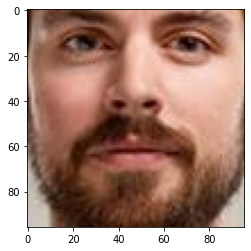

In [28]:
# Load and show second example
example2 = mpimg.imread("emotion_recognition/example_images/neutral.jpg")
print(example2.shape)
plt.imshow(example2)

# Preprocess second example
image_tf = mk_gray_tensor(example2)
print(image_tf.shape)

In [29]:
# Predict emotion for the second example
y_pred, y_probabilities = pic_to_exp.predict_emotion(image_tf)
print(f"The predicted emotion is: {y_pred}\nThe probabilities are: {y_probabilities}")

# Show predictions
EXPRESSIONS_LIST = ['neutral','happy','surprise', 'sad','anger', 'disgust','fear']
exp_probs = pd.DataFrame(data=y_probabilities.T,index=EXPRESSIONS_LIST,columns=["Probability"])
exp_probs["Probability"] = pd.Series([round(val, 4) for val in exp_probs["Probability"]],index = exp_probs.index)
exp_probs

The predicted emotion is: neutral
The probabilities are: [[5.5343539e-01 2.6135294e-02 1.0629379e-04 4.2028123e-01 1.9430334e-05
  2.2319518e-05 3.6441534e-09]]


,Probability
neutral,0.5534
happy,0.0261
surprise,0.0001
sad,0.4203
anger,0.0000
disgust,0.0000
fear,0.0000


### Benchmarking
- The next cells show our benchmarking results to illustrate how different emotion recognition models compare to each other.<br>
- **These benchmarking cells can not be run from this notebook. They were copied from the benchmarking notebook in the repository folder `emotion_recognition`. <br>Please refer to that file to see our benchmarking process and an analysis of the results.**

<ipython-input-79-8e7e8b63c0a0>:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(keys)


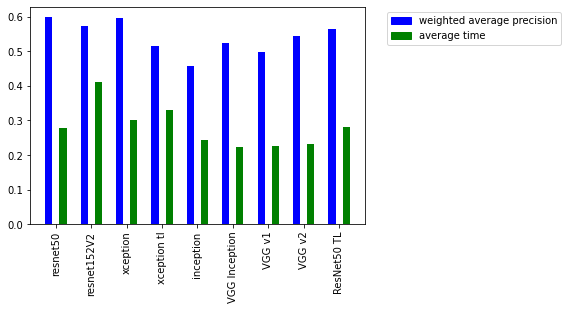

In [79]:
# plot the results
keys = [key for key in performance_dict_combined_clean.keys()]
values = [value for value in performance_dict_combined_clean.values()]

fig, ax = plt.subplots()

ax.bar(np.arange(len(keys)) - 0.2, [value[0] for value in values],
       width=0.2, color='b', align='center')

ax.bar(np.arange(len(keys)) + 0.2,
       [value[1] if len(value) == 2 else 0 for value in values],
       width=0.2, color='g', align='center')

ax.set_xticklabels(keys)
ax.set_xticks(np.arange(len(keys)))
plt.xticks(rotation=90)

colors = {'weighted average precision':'blue', 'average time':'green'}  
labels = list(colors.keys())
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
plt.legend(handles, labels, bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

As we can see from the barplot above, ResNet50 is the model that achieves the highes weighted average precision while still keeping the average prediction time under 0.3 seconds.

In [80]:
# create a dataframe and export the data
performance_df=pd.DataFrame.from_dict(performance_dict_combined_clean,orient='index')
# add the columsn names
performance_df.columns = ["weighted average precision", "average time"]
performance_df

,weighted average precision,average time
resnet50,0.599480,0.277651
resnet152V2,0.573488,0.412500
xception,0.597263,0.300215
xception tl,0.515158,0.328867
inception,0.456254,0.243106
VGG Inception,0.524914,0.224306
VGG v1,0.497851,0.226173
VGG v2,0.542946,0.230954
ResNet50 TL,0.564591,0.280266


 <br>
 
# __3. Full Project Integration__

- This section demonstrates our final program after combining the three individual parts.
- It is able to output a live video with bounding boxes and classifications and saves the results into a Pandas DataFrame and .json file serving as our database.
- In a real business application, SQL would be an option for a proper database implementation.

## Initialization

In [30]:
# Import relevant packages for this section
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import time
import cv2

# Import Full-Model-Integration scripts from repository
# this might take a minute since the models load
# a warning might pop up, but that is not a problem
from full_project_integration import full_model as fm
from full_project_integration import database_mgmt as dm

In [31]:
# Setup database with some example images (e.g. pictures of people when they entered the store)
folder = 'full_project_integration/data/entrance_images' # set to None for an empty database
database = dm.create_database(folder=folder)

# Alternatively a prefilled database can be loaded with
#filepath = 'full_project_integration/db_example.json'
#database = dm.load_database_json(filepath=filepath)

# Show database
print("Database loaded:", database, sep='\n')

# The database can be saved with
filepath = 'full_project_integration/db_example.json'
dm.save_database_json(database, filepath)

Database loaded:
      Timestamp                                              Image  \
0  1.607006e+09  [[[0.7058823529411765, 0.5294117647058824, 0.4...   
1  1.607006e+09  [[[0.34901960784313724, 0.2784313725490196, 0....   
2  1.607006e+09  [[[0.41568627450980394, 0.41568627450980394, 0...   
3  1.607006e+09  [[[0.4980392156862745, 0.3568627450980392, 0.2...   
4  1.607006e+09  [[[0.7372549019607844, 0.5647058823529412, 0.4...   
5  1.607006e+09  [[[0.6588235294117647, 0.5333333333333333, 0.4...   

                                           Embedding        UserID   Emotion  \
0  [0.03510561, -0.17830202, -0.092373505, 0.2761...    Macron.jpg       sad   
1  [-0.12845145, -0.03771121, 0.1686382, -0.01463...  Melania.jpeg  surprise   
2  [-0.038592845, -0.047175996, -0.053563125, -0....    Merkel.jpg   neutral   
3  [0.037902277, -0.015133078, 0.08732595, 0.0848...      Musk.jpg     happy   
4  [-0.05662247, 0.0005982113, 0.04689081, -0.139...     Obama.jpg     happy   
5  [-0.05013

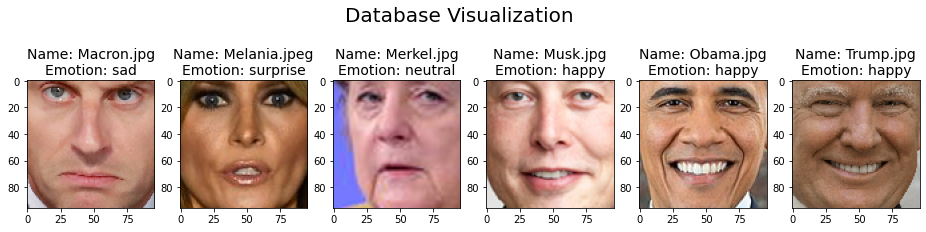

In [32]:
# Visualize database
dm.visualize_database(database)

## Image Example
- Let's assume one of the store cameras takes the following photo in front of a new marketing campaign.<br>
- The next cells show how our model would take this image as an input, detect the faces, recognize the customer from the people that entered the store (in the database), recognizes their emotions, and appends all this to the exiting database.<br>
- Afterwards the database is visualized again and you can see the results. All people and emotions were recognized correctly.

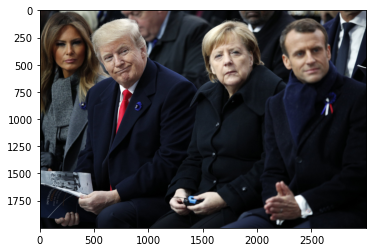

In [33]:
# Load an example image
image = mpimg.imread('full_project_integration/data/politicians.jpg')
plt.imshow(image)

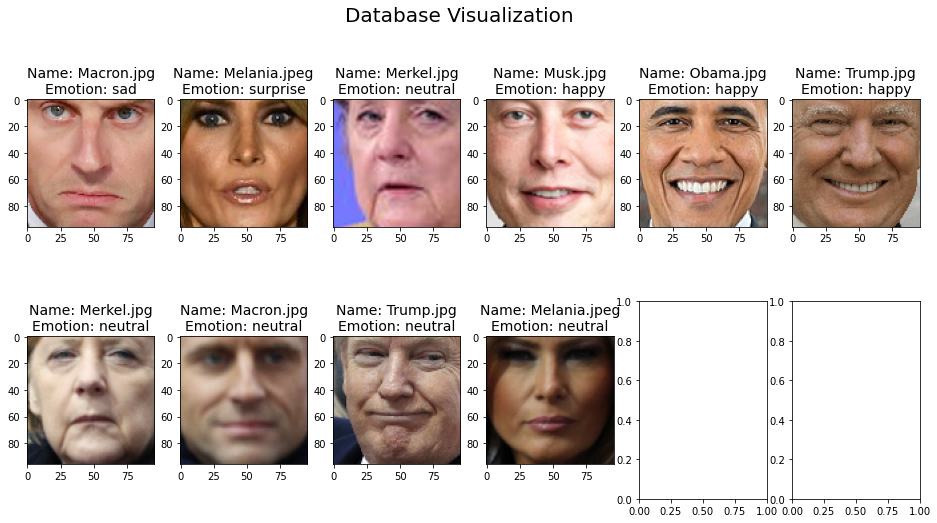

In [34]:
# Give the image into the full model
full_model_output = fm.full_model(image, database)[0]

# Append the output to the database
dm.update_database(database, full_model_output)

# Show updated database
dm.visualize_database(database)

## Webcam Example (try it yourself)

In [35]:
# Load known images to json database
# To be recognized you should load some images of you in the database. You can do this by putting some photos of you in a folder and run this function:
database = dm.create_database(folder='own_images') # THIS PATH IS NOT IN THE REPOSITORY! Put your own folder path with your images here.
# Note: The file names will be used as recognition labels

In [37]:
# Define path to webcam
path_to_vid = 0 #webcam

# start reading video
video_capture = cv2.VideoCapture(path_to_vid)

process_this_frame = True

while True:
    
    # Grab a single frame of video
    ret, frame = video_capture.read()
    
    # Resize frame of video to 1/4 size for faster face recognition processing
    small_frame = cv2.resize(frame, (0, 0), fx=0.25, fy=0.25)
    
    # Only process every other frame of video to save time
    if process_this_frame:
        image = small_frame.copy()
        small_frame = small_frame[..., ::-1]
        full_model_output, det_faces = fm.full_model(image, database)
    
    process_this_frame = not process_this_frame
    
    img_height, img_width, _ = frame.shape
    
    for ann, output in zip(det_faces, full_model_output):
        # bbox
        x1, y1, x2, y2 = int(ann[0] * img_width), int(ann[1] * img_height), \
                         int(ann[2] * img_width), int(ann[3] * img_height)
        cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 1)

        font = cv2.FONT_HERSHEY_DUPLEX
        
        # confidence
        text = "{:.4f}".format(ann[15])
        cv2.putText(frame, text, (int(ann[0] * img_width), int(ann[1] * img_height)), 
                    font, 0.3, (255, 255, 255))
    
        name = output[3]
        emotion = output[4]
    
        # Draw a label with a name below the face
        cv2.rectangle(frame, (x1, y2 -40), (x2, y2), (0, 255, 0), cv2.FILLED)
        
        cv2.putText(frame, name, (x1 + 6, y2 - 24), font, 0.6, (255, 255, 255), 2)
        cv2.putText(frame, emotion, (x1 + 6, y2 - 6), font, 0.6, (255, 255, 255), 2)
    

    # Display the resulting image
    cv2.imshow('Video', frame)

    # Hit 'q' on the keyboard to quit!
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release handle to the webcam
video_capture.release()
cv2.destroyAllWindows()

## Appendix: Create images for our presentation

In [38]:
# Setup database with some example images (e.g. pictures of people when they entered the store)
folder = 'full_project_integration/data/entrance_images' # set to None for an empty database
database = dm.create_database(folder=folder)

#### Elon Musk

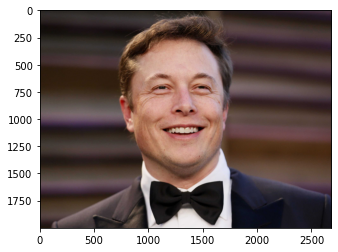

In [39]:
# Load an example image
frame = mpimg.imread('full_project_integration/data/presentation1in.jpg')
frame = cv2.resize(frame, (2679, 2000)) # for specific display in presentation
plt.imshow(frame)

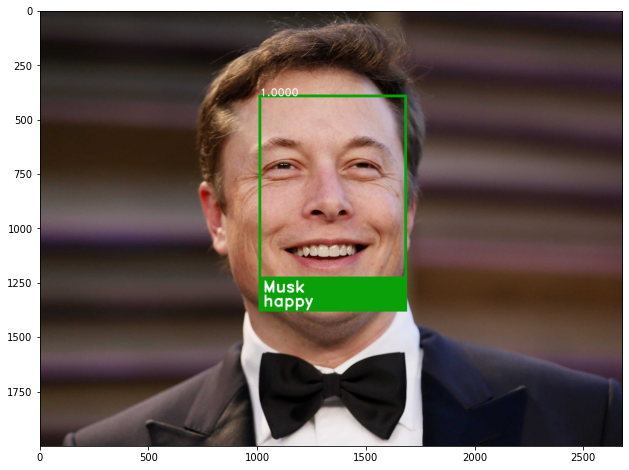

In [40]:
# Only process every other frame of video to save time
image = frame.copy()
full_model_output, det_faces = fm.full_model(image, database)
img_height, img_width, _ = frame.shape
    
for ann, output in zip(det_faces, full_model_output):
    
    # bbox
    x1, y1, x2, y2 = int(ann[0] * img_width), int(ann[1] * img_height), \
                         int(ann[2] * img_width), int(ann[3] * img_height)
    cv2.rectangle(frame, (x1, y1), (x2, y2), (10, 160, 10), 12)

    # text
    font = cv2.FONT_HERSHEY_DUPLEX
        
    # confidence
    text = "{:.4f}".format(ann[15])
    cv2.putText(frame, text, (int(ann[0] * img_width), int(ann[1] * img_height)), 
                    font, 1.6, (255, 255, 255), 2)
    
    # name and emotion
    cv2.rectangle(frame, (x1 - 6, y2 - 40), (x2 + 6, y2 + 120), (10, 160, 10), cv2.FILLED)
    name = output[3]
    if name[-4:] == '.jpg':
        name = name[:-4]
    emotion = output[4]    
    cv2.putText(frame, name, (x1 + 15, y2 + 30), font, 2.4, (255, 255, 255), 6)
    cv2.putText(frame, emotion, (x1 + 15, y2 + 95), font, 2.4, (255, 255, 255), 6)
    
# Display the resulting image
plt.figure(figsize = (16,8))
plt.imshow(frame)

In [41]:
plt.imsave('full_project_integration/data/presentation1out.jpg', frame)

#### Final picture

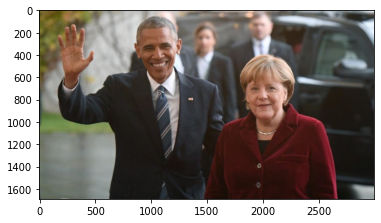

In [42]:
# Load an example image
frame = mpimg.imread('full_project_integration/data/presentation2in.jpg')
frame = cv2.resize(frame, (3000, 1689)) # for specific display in presentation
plt.imshow(frame)

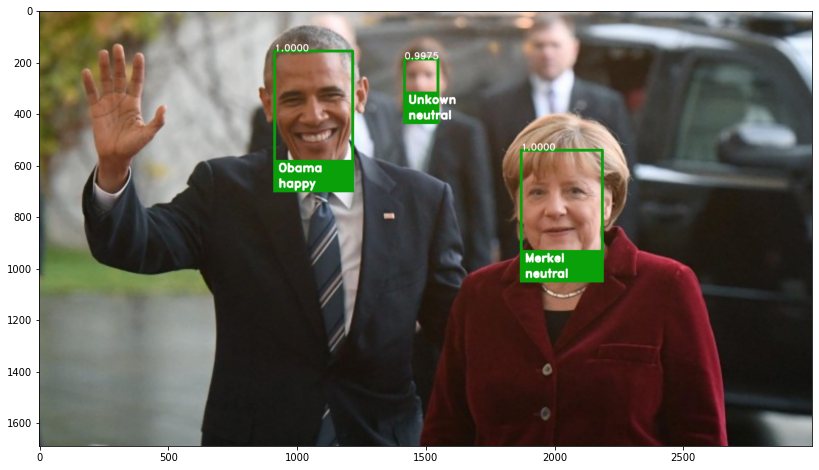

In [43]:
# Only process every other frame of video to save time
image = frame.copy()
full_model_output, det_faces = fm.full_model(image, database)
img_height, img_width, _ = frame.shape
    
for ann, output in zip(det_faces, full_model_output):
    
    # bbox
    x1, y1, x2, y2 = int(ann[0] * img_width), int(ann[1] * img_height), \
                         int(ann[2] * img_width), int(ann[3] * img_height)
    cv2.rectangle(frame, (x1, y1), (x2, y2), (10, 160, 10), 10)

    # text
    font = cv2.FONT_HERSHEY_DUPLEX
        
    # confidence
    text = "{:.4f}".format(ann[15])
    cv2.putText(frame, text, (int(ann[0] * img_width), int(ann[1] * img_height)), 
                    font, 1.2, (255, 255, 255), 2)
    
    # name and emotion
    cv2.rectangle(frame, (x1 - 5, y2 - 40), (x2 + 5, y2 + 85), (10, 160, 10), cv2.FILLED)
    name = output[3]
    if name[-4:] == '.jpg':
        name = name[:-4]
    emotion = output[4]    
    cv2.putText(frame, name, (x1 + 15, y2 + 5), font, 1.5, (255, 255, 255), 5)
    cv2.putText(frame, emotion, (x1 + 15, y2 + 65), font, 1.5, (255, 255, 255), 5)
    
# Display the resulting image
plt.figure(figsize = (16,8))
plt.imshow(frame)

In [44]:
plt.imsave('full_project_integration/data/presentation2out.jpg', frame)